# Introduction & Context

### The MCP Hype vs. Reality
The Model Context Protocol (MCP) has been generating lots of hype in the AI community lately, and for good reason. It represents a standardized way for LLMs to interact with external tools and services. But with all the excitement, it's important to cut through the hype and understand what MCP really is.

MCP isn't revolutionary new technology - it's a (potentially) revolutionary new standard. If you've been working with AI systems/agents for any length of time, you've already been implementing the core concept: giving LLMs access to tools through function calling. What's different is that MCP provides a standardized protocol for these interactions.



## Part 2: Understanding MCP at a Technical Level

### MCP Architecture Overview

The Model Context Protocol follows a client-host-server architecture:
This separation of concerns allows for modular, composable systems where each server can focus on a specific domain (like file access, web search, or database operations).

- **MCP Hosts**: Programs like Claude Desktop, IDEs, or your python application that want to access data through MCP
- **MCP Clients**: Protocol clients that maintain 1:1 connections with servers
- **MCP Servers**: Lightweight programs that each expose specific capabilities through the standardized Model Context Protocol (tools, resources, prompts)
- **Local Data Sources**: Your computer's files, databases, and services that MCP servers can securely access
- **Remote Services**: External systems available over the internet (e.g., through APIs) that MCP servers can connect to

This separation of concerns allows for modular, composable systems where each server can focus on a specific domain (like file access, web search, or database operations).

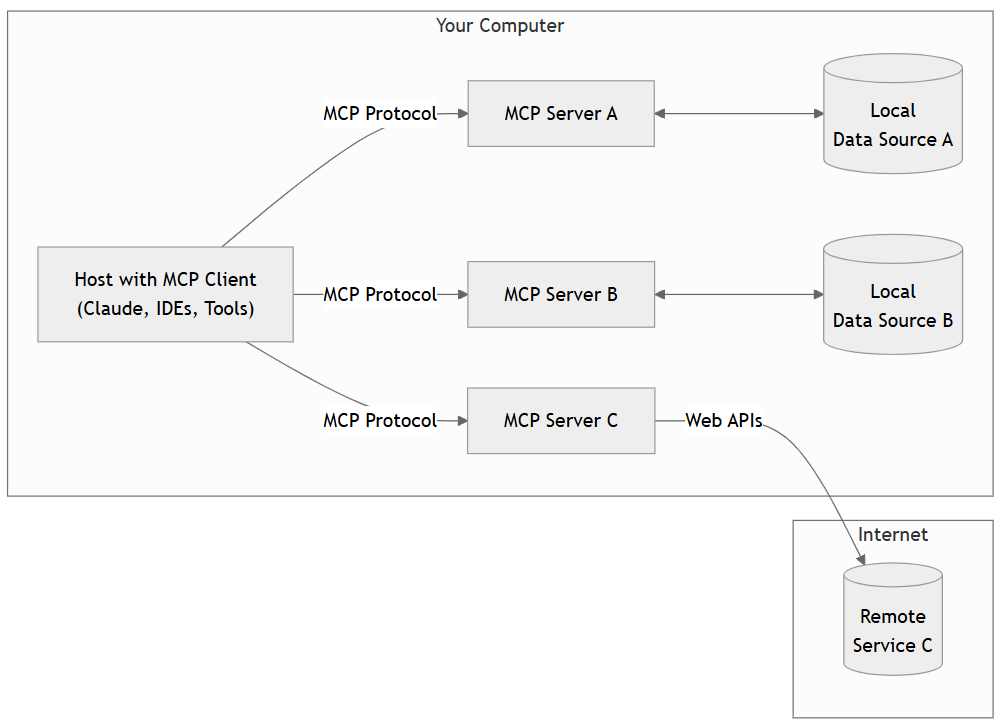

MCP defines three core primitives that servers can implement:

1. [Tools](https://modelcontextprotocol.io/docs/concepts/tools#python): Model-controlled functions that LLMs can invoke (like API calls, computations)
2. [Resources](https://modelcontextprotocol.io/docs/concepts/resources#python): Application-controlled data that provides context (like file contents, database records)
3. [Prompts](https://modelcontextprotocol.io/docs/concepts/prompts#python): User-controlled templates for LLM interactions

For Python developers, the most immediately useful primitive is tools, which allow LLMs to perform actions programmatically.

### Transport Mechanisms Deep Dive

MCP supports three main transport mechanisms:

1. **Stdio (Standard IO)**: 
   - Communication occurs over standard input/output streams
   - Best for local integrations when the server and client are on the same machine
   - Simple setup with no network configuration required

2. **SSE (Server-Sent Events)**:
   - Uses HTTP for client-to-server communication and SSE for server-to-client
   - Suitable for remote connections across networks
   - Allows for distributed architectures

3. **Streamable HTTP** *(Introduced March 24, 2025)*:
   - Modern HTTP-based streaming transport that supersedes SSE
   - Uses a unified endpoint for bidirectional communication
   - **Recommended for production deployments** due to better performance and scalability
   - Supports both stateful and stateless operation modes

Understanding when to use each transport is crucial for building effective MCP implementations:

- Use **Stdio** when building single-application integrations or during development
- Use **SSE** for development or when working with older MCP implementations
- Use **Streamable HTTP** for production deployments where you need the best performance and scalability

#### Transport Mechanism Comparison

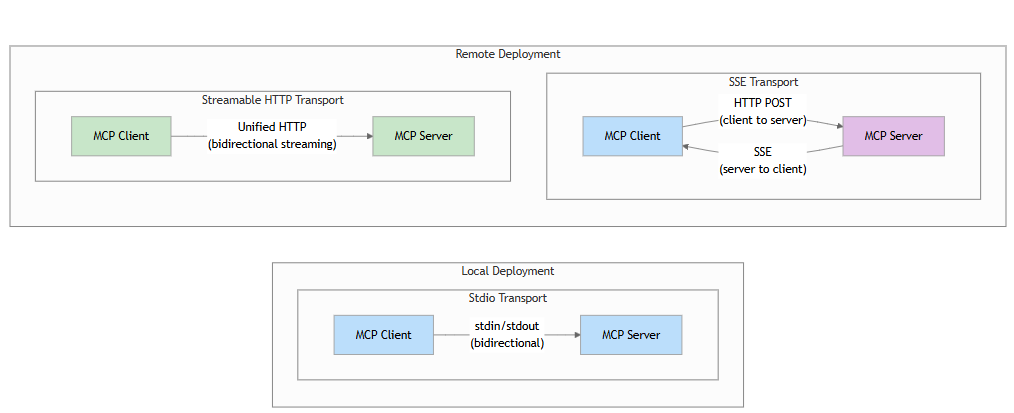

If you're familiar with FastAPI, you'll find that implementing an MCP server with HTTP transports (both SSE and Streamable HTTP) feels very similar. Both frameworks use HTTP endpoints for receiving requests and support streaming responses. They both allow you to define handlers for specific routes/endpoints and provide async/await patterns for handling requests and generating responses. This similarity makes it easy for FastAPI developers to transition to building MCP servers, as they can leverage their existing knowledge of HTTP, async programming, and streaming responses.

### A New Standard

The true power of MCP isn't in introducing new capabilities, but in standardizing how these capabilities are exposed and consumed. This provides several key advantages:

- **Reusability**: Build a server once, use it with any MCP-compatible client
- **Composability**: Combine multiple servers to create complex capabilities
- **Ecosystem growth**: Benefit from servers created by others

The MCP ecosystem is already growing rapidly, with servers available many tools. You can find an overview here: [Officially supported servers](https://github.com/modelcontextprotocol/servers)

This means you can leverage existing servers rather than reinventing the wheel, and contribute your own servers to benefit the community.

# MCP Server - Tool Orchestration Flow

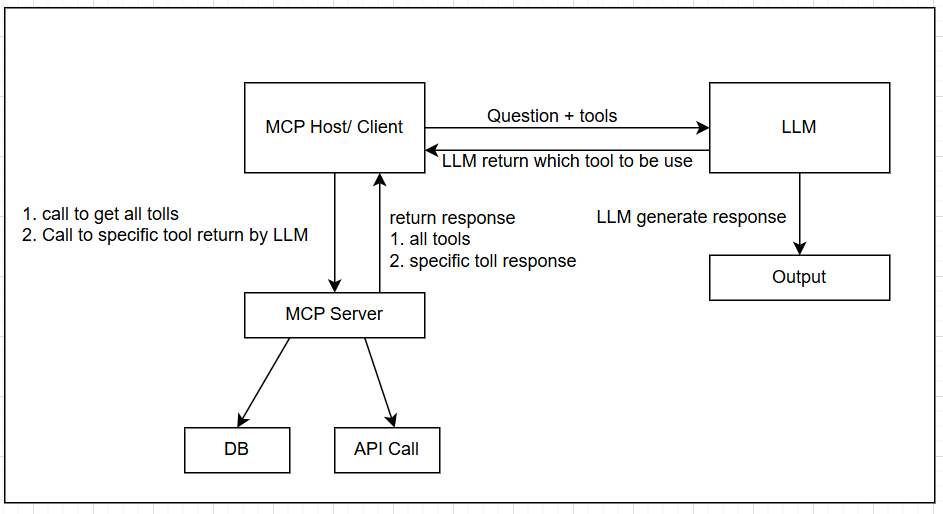

1. Tool Discovery (Initial Setup)

    - MCP Server maintains a list of configured tools (API endpoints/services) available for execution.

    - When a client connects, MCP Server sends the list of available tools to the client.

2. Client Request

    - The client sends a user query along with the tool list to the LLM (Large Language Model).

    - Example: “What’s the weather and best hotels in Paris?”

3. LLM Reasoning & Tool Selection

    - LLM analyzes the query and determines which tools from the list are required.

    - LLM returns the selected tool names and any required parameters to the client.

4. Tool Invocation via MCP Server

    - Client sends a new request to the MCP Server specifying:

        - Tool name(s) to invoke

        - Parameters for each tool
    - MCP Server invokes the selected tool(s) and gathers the raw responses.

5. Response Delivery

    - MCP Server sends tool responses back to the client.

6. Final Response Generation

    - Client forwards tool outputs to the LLM.

    - LLM generates a final natural language response using the raw tool outputs.

7. Client shows the final output to the end user.

### What Happens When We Run an MCP Server?
When you run an MCP server:

The server initializes with the capabilities you've defined (tools, resources, etc.)
It starts listening for connections on a specific transport
By default, MCP servers don't use a traditional web server port. Instead, they use either:

- stdio transport: The server communicates through standard input and output (the default for mcp run and integration with Claude Desktop)
- SSE transport: For HTTP-based communication (used when explicitly configured)

If you want to expose your server over HTTP with a specific port, you need to modify your server to use the SSE transport:


- mcp = FastMCP("MyServer", host="127.0.0.1", port=8050)




### MCP Project Structure & Purpose
1. server.py – MCP Server Initialization
- Defines and registers all tools (e.g., add, subtract, etc.)

- Initializes the MCP server using FastMCP.

- Accepts a command-line argument to specify the transport layer (sse, stdio, or streamable-http).

- Runs the server accordingly using mcp.run_async().

2. client-sse.py – SSE-Based Client
- Used when the server is running with the SSE transport (python server.py sse).

- Sends a POST request to the server’s /stream endpoint on port 8050.

- Listens for Server-Sent Events (SSE) and receives streamed results.

- Suitable for interactive and incremental responses.

3. client-stdio.py – STDIO-Based Client
- Used when the server runs with the stdio transport (python server.py stdio or invoked by the client).

- Communicates with the server through standard input/output pipes.

- Launches the server as a subprocess and exchanges data over stdin/stdout.

- Lightweight and ideal for local CLI-based toolchains.

4. client-streamable-http.py – Streamable HTTP Client
- Used when the server is running with the streamable-http transport (python server.py streamable-http).

- Sends a standard HTTP POST request to /invoke (usually on port 8000).

- Gets back a JSON response from the server.

- Useful for synchronous, REST-style communication and easy integration with other services.

### Which Approach Should We Choose?
- Use stdio if your client and server will be running in the same process or if you're starting the server process directly from your client.
- Use Streamable HTTP for production deployments where you need the best performance and scalability.
- Use SSE for development or when working with older MCP implementations that don't yet support Streamable HTTP.

For most production backend integrations, the Streamable HTTP approach offers the best performance and modern architecture, while stdio might be simpler for development or tightly coupled systems.